# Data

In [38]:
from dotenv import load_dotenv
load_dotenv()

True

## 01 data loading

In [39]:
import os
import pandas as pd
import numpy as np

In [ ]:
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
x_path = os.path.join(base_path,os.getenv("X_LABEL"))
y_path = os.path.join(base_path,os.getenv("Y_LABEL"))

In [41]:
x_df = pd.read_csv(x_path) 
y_df = pd.read_csv(y_path) 

In [42]:
y_df=y_df.drop(columns=["年份","季別"])
x_df=x_df.drop(columns=["年份","季別"])

In [43]:
y_df

,GDP
0,461774
1,488234
2,489504
3,498511
4,495361
...,...
163,5896191
164,5489013
165,5710934
166,6016101


In [44]:
x_df

,平均匯率(元/美元),國內投資毛額,投資率,工業生產指數,製造業銷售量指數,電力(企業)總用電量(十億度),進口物價基本分類指數,出口物價基本分類指數,進口貿易總值,出口貿易總值,機械及電機設備進口值(十億元),消費者物價指數,失業率,就業人數（千人）,總人口數(千人),景氣領先指標綜合指數(點),景氣同時指標綜合指數(點),gdp_t1,gdp_t2,gdp_t3
0,37.91,102048,22.10,27.57,30.02,4.85,231.63,311.21,147089.00,135223.67,0.00,129.59,3.42,15826.00,42389.67,28.72,30.21,NaN,NaN,NaN
1,38.78,143589,29.41,30.35,33.54,5.46,231.87,315.17,172059.67,156827.00,0.00,130.53,4.12,15577.33,42570.33,28.81,29.00,461774.0,NaN,NaN
2,39.65,117934,24.09,30.06,32.76,5.81,234.50,317.22,181502.67,148698.00,0.00,133.10,5.75,16000.33,42742.00,28.50,28.87,488234.0,461774.0,NaN
3,40.15,144192,28.92,29.86,32.70,5.66,234.53,315.38,168145.00,135928.00,0.00,132.11,6.41,16146.33,42952.67,29.05,29.58,489504.0,488234.0,461774.0
4,39.97,99632,20.11,29.28,31.80,5.21,227.62,309.54,153110.00,131671.00,0.00,132.95,7.15,16260.67,43145.67,31.46,30.78,498511.0,489504.0,488234.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,31.37,1588290,26.94,220.26,211.99,32.25,275.24,267.03,2781303.00,2520472.00,1162.68,241.98,8.42,26657.00,53816.00,218.08,215.55,5718537.0,5558046.0,5647656.0
164,30.40,1520462,27.70,188.21,187.55,28.45,263.12,253.88,2259435.33,2073891.33,925.86,243.54,8.22,26787.33,54002.33,220.45,206.97,5896191.0,5718537.0,5558046.0
165,30.71,1426025,24.97,188.72,195.97,31.84,257.68,252.57,2533770.00,2111711.00,890.73,245.20,8.12,26852.33,54117.67,219.13,204.78,5489013.0,5896191.0,5718537.0
166,31.69,1364758,22.69,205.88,207.63,34.72,260.87,258.10,2794123.00,2151759.33,973.80,246.62,8.28,26936.00,54213.00,216.33,207.60,5710934.0,5489013.0,5896191.0


## 02 data MinMaxScaler

In [45]:
from sklearn.preprocessing import MinMaxScaler

In [46]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(x_df)
y_scaled = scaler_y.fit_transform(y_df)

In [47]:
X_seq,y_seq=[],[]


for i in range(5,len(X_scaled)):
    X_seq.append([X_scaled[i]])

for i in range(5,len(y_scaled)):
    y_seq.append([y_scaled[i]])

X_seq=np.array(X_seq)
y_seq=np.array(y_seq)


## 03 data spliting 80 & 20

In [48]:
train_size = int(len(X_seq) * 0.8)
lstm_X_train, lstm_X_test = X_seq[:train_size], X_seq[train_size:]
lstm_y_train, lstm_y_test = y_seq[:train_size], y_seq[train_size:]


# Model-LSTM

- train 1983 Q2 to 2015 Q3
- test  2015 Q4 to 2023 Q4

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt

In [34]:
def evaluate_performance(y_true_scaled, y_pred_scaled, scaler, dataset_name=""):
    y_true = scaler.inverse_transform(y_true_scaled)
    y_pred = scaler.inverse_transform(y_pred_scaled)

    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)

    print(f"\n📊 {dataset_name} Performance:")
    print(f"  MSE:  {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")

In [51]:
def plot_gdp_forecast(year,name,train_actual, train_pred, test_actual, test_pred):
    plt.figure(figsize=(12, 6))

    # 畫出四條線
    plt.plot(year.iloc[5:135],train_actual, label='Train Actual', color='blue', linestyle='-')
    plt.plot(year.iloc[5:135],train_pred, label='Train Predicted', color='cyan', linestyle='--')
    plt.plot(year.iloc[135:],test_actual, label='Test Actual', color='green', linestyle='-')
    plt.plot(year.iloc[135:],test_pred, label='Test Predicted', color='orange', linestyle='--')

    # 標題與座標軸
    plt.title(f'GDP Forecast with {name}', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('GDP Value', fontsize=14)

    plt.xticks(year,rotation=45)
    
    # 顯示圖例
    plt.legend()

    # 顯示網格
    plt.grid(True, linestyle='--', alpha=0.7)

    # 顯示圖片
    plt.show()

In [35]:
model = Sequential()
model.add(LSTM(64, input_shape=(lstm_X_train.shape[1], lstm_X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

model.fit(lstm_X_train, lstm_y_train, epochs=50, batch_size=7)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,825 (85.25 KB)

 Trainable params: 21,825 (85.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0520   
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093 
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9212e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4278e-04 
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1829e-04
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8820e-04 
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8229e-04 
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4131e-04 
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1351e-04 
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5298e-04 
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1886e-04 
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5248e-04 
Epoch 15/50
19/19 ━━━━━━━━━━━━━

In [36]:
# 預測
y_train_pred_scaled = model.predict(lstm_X_train)
y_pred_lstm_train = scaler_y.inverse_transform(y_train_pred_scaled)
y_true_lstm_train = scaler_y.inverse_transform(lstm_y_train.reshape(-1, 1))


y_test_pred_scaled = model.predict(lstm_X_test)
y_pred_lstm_test = scaler_y.inverse_transform(y_test_pred_scaled)
y_true_lstm_test = scaler_y.inverse_transform(lstm_y_test.reshape(-1, 1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [37]:
# 執行評估
evaluate_performance(lstm_y_train.reshape(-1, 1), y_train_pred_scaled, scaler_y, dataset_name="Train Set")
evaluate_performance(lstm_y_test.reshape(-1, 1), y_test_pred_scaled, scaler_y, dataset_name="Test Set")


📊 Train Set Performance:
  MSE:  3563044743.85
  RMSE: 59691.25
  MAE:  45202.16

📊 Test Set Performance:
  MSE:  124982007790.70
  RMSE: 353527.94
  MAE:  263236.70


In [53]:
year_df = pd.read_csv(y_path) 
year_df=year_df['年份']

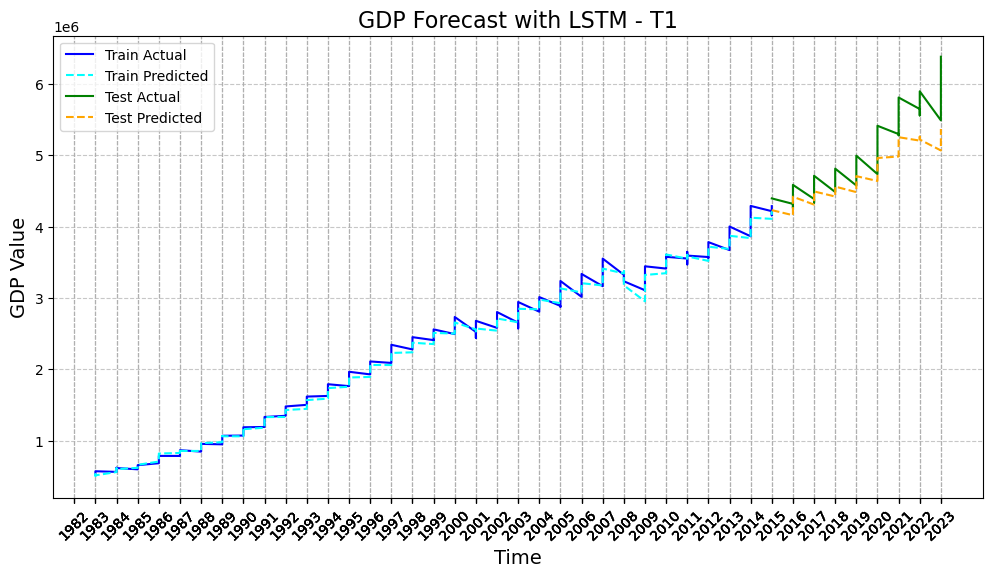

In [55]:
plot_gdp_forecast(year_df,'LSTM - T1',y_true_lstm_train,y_pred_lstm_train,y_true_lstm_test,y_pred_lstm_test)